In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
# Modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)



import warnings

In [17]:
df = pd.read_parquet('../artifacts/train.parquet')

In [6]:
df.head()

,repo,issue_id,issue_number,events,text_size,content,usernames
0,ms-iot/vscode-ros,656314577,260,"[{'action': 'opened', 'author': 'cwillia109', ...",1480,<issue_start><issue_comment>Title: [bug] Could...,"[""nightduck"", ""BlueBirdHouse"", ""PeripateticWin..."
1,mspnp/iot-journey,104771648,312,"[{'action': 'opened', 'author': 'bennage', 'co...",1157,<issue_start><issue_comment>Title: Replace pro...,"[""bennage""]"
2,dedale-fet/alpha-transform,655180157,2,"[{'action': 'opened', 'author': 'matteo-ronche...",301,<issue_start><issue_comment>Title: Create pip ...,"[""matteo-ronchetti""]"
3,Microsoft/TypeScript-TmLanguage,139215441,113,"[{'action': 'opened', 'author': 'felixfbecker'...",536,<issue_start><issue_comment>Title: Methods som...,"[""felixfbecker"", ""sheetalkamat""]"
4,dotnet/core,1000872533,6719,"[{'action': 'opened', 'author': 'w00w00w', 'co...",464,<issue_start><issue_comment>Title: help\nusern...,"[""tannergooding"", ""w00w00w""]"


In [7]:
df['content'][0]

'<issue_start><issue_comment>Title: [bug] Could not source the setup file for ROS distro\nusername_0: **general information**\r\nOS: Ubuntu 18.04\r\nPlugin: 0.6.3\r\nVS Code: 1.47.0\r\nROS Distro: Melodic\r\n\r\n**what is the bug**\r\nUsing a fresh install of visual studio code, the extension gives a "Could not source the setup file for ROS distro \'/opt/ros/melodic/setup.bash\'"\r\n\r\n**expected behavior**\r\nThe plugin is able to source the ROS setup.\r\n\r\n**additional context**\r\nHave tried this with the previous 2 versions of the plugin, neither worked. Python is also able to get ROS related autocomplete, but not C++.\n<issue_comment>username_1: My environment is the same as yours, and encountered the same problem.\n<issue_comment>username_2: The user-fix I found is to select the "workspace" tab in the extension\'s settings and type "melodic" into the distro box.\r\n![scrot](https://user-images.githubusercontent.com/10158631/94978248-254f3500-04e2-11eb-83c8-6f25dfe622cd.png)\n<

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131497 entries, 0 to 131496
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   repo          131497 non-null  object
 1   issue_id      131497 non-null  int64 
 2   issue_number  131497 non-null  int64 
 3   events        131497 non-null  object
 4   text_size     131497 non-null  int64 
 5   content       131497 non-null  object
 6   usernames     131497 non-null  object
dtypes: int64(3), object(4)
memory usage: 7.0+ MB


In [18]:
def parse_events_min(events):
    """
    Return only the columns we need for modeling/analysis:
      - opened_at
      - closed_at
      - is_closed
      - lifecycle_hours
      - comment_count
      - first_response_minutes
      - bot_first_response
      - participants_count
    """
    opened_at = None
    created_at = None
    closed_at = None
    first_comment_at = None
    comment_count = 0
    participants = set()

    if not isinstance(events, (list, tuple)):
        return {
            "opened_at": None,
            "created_at":None,
            "closed_at": None,
            "is_closed": False,
            "lifecycle_hours": None,
            "comment_count": 0,
            "first_response_minutes": None,
            "bot_first_response": None,
            "participants_count": 0,
        }

    for ev in events:
        ev_type = (ev.get("type") or "").lower()       # 'issue' | 'comment' | ...
        action  = (ev.get("action") or "").lower()     # 'opened' | 'closed' | 'created' ...
        author  = ev.get("author")
        dt      = pd.to_datetime(ev.get("datetime"), utc=True, errors="coerce")

        if author:
            participants.add(author)

        if ev_type == "issue" and action == "opened" and opened_at is None:
            opened_at = dt
        if ev_type == "comment" and action == "created" and created_at is None:
            created_at = dt
        elif ev_type == "issue" and action == "closed" and closed_at is None:
            closed_at = dt
        elif ev_type == "comment":
            comment_count += 1
            if first_comment_at is None:
                first_comment_at = dt

    is_closed = closed_at is not None

    lifecycle_hours = (
        (closed_at - opened_at).total_seconds() / 3600.0
        if opened_at is not None and closed_at is not None
        else None
    )

    first_response_minutes = (
        (first_comment_at - opened_at).total_seconds() / 60.0
        if opened_at is not None and first_comment_at is not None
        else None
    )

    return {
        "opened_at": opened_at,
        "created_at" :created_at,
        "closed_at": closed_at,
        "is_closed": is_closed,
        "lifecycle_hours": lifecycle_hours,
        "comment_count": int(comment_count),
        "first_response_minutes": first_response_minutes,
        "participants_count": int(len(participants)),
    }

In [19]:
fe = df["events"].apply(parse_events_min).apply(pd.Series)
df = pd.concat([df, fe], axis=1)

In [20]:
#filter for only rows where df is_close == True
df_model = df[
    (df["is_closed"] == True) & 
    (df["lifecycle_hours"].notna())
].copy()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131497 entries, 0 to 131496
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   repo                    131497 non-null  object
 1   issue_id                131497 non-null  int64 
 2   issue_number            131497 non-null  int64 
 3   events                  131497 non-null  object
 4   text_size               131497 non-null  int64 
 5   content                 131497 non-null  object
 6   usernames               131497 non-null  object
 7   opened_at               0 non-null       object
 8   created_at              0 non-null       object
 9   closed_at               0 non-null       object
 10  is_closed               131497 non-null  bool  
 11  lifecycle_hours         0 non-null       object
 12  comment_count           131497 non-null  int64 
 13  first_response_minutes  0 non-null       object
 14  bot_first_response      0 non-null  

In [84]:
#create new col for missing first response 
df_model["first_response_missing"] = df_model["first_response_minutes"].isna().astype(int)
df_model["first_response_minutes"].fillna(-1, inplace=True)


/var/folders/nl/4plg4prn2w39wf8d2gclsmqc0000gn/T/ipykernel_39339/2976619631.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model["first_response_minutes"].fillna(-1, inplace=True)


In [85]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240420 entries, 0 to 337135
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   repo                    240420 non-null  object 
 1   issue_id                240420 non-null  int64  
 2   issue_number            240420 non-null  int64  
 3   events                  240420 non-null  object 
 4   text_size               240420 non-null  int64  
 5   content                 240420 non-null  object 
 6   usernames               240420 non-null  object 
 7   created_at              0 non-null       float64
 8   opened_at               239833 non-null  object 
 9   closed_at               240420 non-null  object 
 10  is_closed               240420 non-null  bool   
 11  lifecycle_hours         240420 non-null  float64
 12  first_response_minutes  240420 non-null  float64
 13  comment_count           240420 non-null  int64  
 14  participants_count      2

In [86]:
#clean up content column
def clean_content(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # remove special tokens like <issue_start>, <issue_comment>, <issue_closed>
    text = re.sub(r"<[^>]+>", " ", text)
    # remove usernames like @username_123
    text = re.sub(r"@\w+", " ", text)
    # remove issue/bug IDs like #TRAC123 or #1234
    text = re.sub(r"#\w+", " ", text)
    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply to dataset
df_model["content_clean"] = df_model["content"].apply(clean_content)

In [87]:

TITLE_RE = re.compile(r"(?i)\btitle:\s*(.+?)\s*(?=username_\d+:|$)")
SPEAKER_RE = re.compile(r"\busername_\d+:\s*")

def split_title_body(text: str):
    if not isinstance(text, str) or not text.strip():
        return "", ""
    # 1) extract title (text after "Title:" up to next speaker or end)
    m = TITLE_RE.search(text)
    title = m.group(1).strip() if m else ""
    # 2) remove title segment (including the "Title:" token) from the body
    body = TITLE_RE.sub(" ", text) if m else text
    # 3) remove speaker tags like "username_1:" from body
    body = SPEAKER_RE.sub(" ", body)
    # 4) collapse whitespace
    body = re.sub(r"\s+", " ", body).strip()
    return title, body

# Apply
df_model[["issue_title", "content_body"]] = df_model["content_clean"].apply(
    lambda t: pd.Series(split_title_body(t))
)


In [88]:
df_model['issue_title']

0         Simple File Silo: Errors aren't submitted to m...
2         Initializing Schema Migrations with "dbo." in ...
3         Support truthy-value shorthand for filters, li...
5                                       Android 2.3 support
6         Downloading assets in development mode takes a...
                                ...                        
337131                   i face problem to run this project
337132                            Port-forwarding times out
337133                              More fields for Country
337134                                    Weird parse error
337135                              Unable to import pandas
Name: issue_title, Length: 240420, dtype: object

In [90]:
# 3-class version
bins   = [0, 24, 168, float("inf")]
labels = ["Short", "Medium", "Long"]

df_model["resolution_class"] = pd.cut(
    df_model["lifecycle_hours"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

print(df_model["resolution_class"].value_counts(normalize=True).mul(100).round(2))


resolution_class
Long      49.99
Short     29.97
Medium    20.04
Name: proportion, dtype: float64


In [92]:
# Drop rows where resolution_class is NaN
df_model = df_model.dropna(subset=["resolution_class"]).copy()

In [93]:
X_cols = [
    #'issue_title',
    "text_size", 
    "comment_count", 
    "participants_count", 
    "first_response_minutes", 
    "first_response_missing"
]

In [94]:
#drop irrelevant columns for modelling resolution time 
X = df_model[X_cols]
y = df_model['resolution_class']

In [95]:
df_model[df_model['resolution_class'].isnull()]

,repo,issue_id,issue_number,events,text_size,content,usernames,created_at,opened_at,closed_at,...,lifecycle_hours,first_response_minutes,comment_count,participants_count,lifecycle_reason,first_response_missing,content_clean,issue_title,content_body,resolution_class


In [96]:
df_model['events'][0]

'[{\'action\': \'opened\', \'author\': \'HabariImporter\', \'comment_id\': None, \'datetime\': \'2011-06-27T00:09:06Z\', \'masked_author\': \'username_0\', \'text\': "Initially reported by: @username_2 as #TRAC453 \\nIt\'d be nice if the error messages in the simple file silo were using the message system. For instance, trying to create a directory named \'/\' will create an error.", \'title\': "Simple File Silo: Errors aren\'t submitted to message system", \'type\': \'issue\'}, {\'action\': \'created\', \'author\': \'Konzertheld\', \'comment_id\': 264033767, \'datetime\': \'2016-11-30 23:47:14+00:00\', \'masked_author\': \'username_1\', \'text\': \'I wonder if @heilemann still uses Habari and can confirm this is fixed (because it is, as I see it).\', \'title\': None, \'type\': \'comment\'}, {\'action\': \'created\', \'author\': \'Heilemann\', \'comment_id\': 264213444, \'datetime\': \'2016-12-01 16:03:22+00:00\', \'masked_author\': \'username_2\', \'text\': "Thank you for thinking of 

#### Preparing X and Y variables

In [ ]:
#Create Column Transformer with 1/2 types of transformers

text_col = "content_clean"
num_cols  = ["text_size","comment_count","participants_count","first_response_minutes","first_response_missing"]

# # Text branch: TF-IDF -> SVD
# text_pipe = Pipeline([
#     ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,1), 
#                               max_df=0.9, min_df=10, stop_words="english")),
#     ("svd", TruncatedSVD(n_components=10, random_state=42))
# ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
    ],
)


In [ ]:
# X = preprocessor.fit_transform(X)

In [99]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((192336, 5), (48084, 5))

In [100]:
# y should be your resolution_class column (strings). Encode to ints.
le = LabelEncoder()
y_train_cls = le.fit_transform(y_train)   # y_train is df column of classes
y_test_cls  = le.transform(y_test)

#### Create an Evaluate Function to give all metrics after model Training

In [101]:
def eval_metrics(y_true, y_pred, le):
    acc   = accuracy_score(y_true, y_pred)
    f1_ma = f1_score(y_true, y_pred, average="macro")
    f1_wt = f1_score(y_true, y_pred, average="weighted")
    prec_ma = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_ma  = recall_score(y_true, y_pred, average="macro", zero_division=0)

    # per-class metrics
    classes = list(le.classes_)  # e.g., ["Short","Medium","Long"]
    p_cls, r_cls, f_cls, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=np.arange(len(classes)), zero_division=0
    )
    # Find indices for "Long" and "Short" if present
    idx_long  = classes.index("Long")  if "Long"  in classes else None
    idx_short = classes.index("Short") if "Short" in classes else None
    recall_long     = r_cls[idx_long]  if idx_long  is not None else np.nan
    precision_short = p_cls[idx_short] if idx_short is not None else np.nan

    return {
        "acc": acc, "f1_macro": f1_ma, "f1_weighted": f1_wt,
        "precision_macro": prec_ma, "recall_macro": rec_ma,
        "recall_long": recall_long, "precision_short": precision_short
    }

In [102]:
models = {
    "LogisticRegression": LogisticRegression(),
    "LinearSVC": LinearSVC(),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
    "CatBoost": CatBoostClassifier(verbose=False),
    "AdaBoost": AdaBoostClassifier()
}

/Users/obinnadinneya/miniconda3/envs/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression
Train | Acc: 0.503  F1-macro: 0.276  Prec-macro: 0.356  Rec-macro: 0.349  Recall(Long): 0.943  Precision(Short): 0.414
Test  | Acc: 0.501  F1-macro: 0.274  Prec-macro: 0.392  Rec-macro: 0.348  Recall(Long): 0.943  Precision(Short): 0.420
----------------------------------------------------------------------
LinearSVC
Train | Acc: 0.499  F1-macro: 0.224  Prec-macro: 0.246  Rec-macro: 0.333  Recall(Long): 0.997  Precision(Short): 0.000
Test  | Acc: 0.498  F1-macro: 0.224  Prec-macro: 0.265  Rec-macro: 0.334  Recall(Long): 0.997  Precision(Short): 0.000
----------------------------------------------------------------------
KNN
Train | Acc: 0.700  F1-macro: 0.656  Prec-macro: 0.676  Rec-macro: 0.645  Recall(Long): 0.826  Precision(Short): 0.719
Test  | Acc: 0.576  F1-macro: 0.516  Prec-macro: 0.526  Rec-macro: 0.512  Recall(Long): 0.725  Precision(Short): 0.578
----------------------------------------------------------------------
RandomForest
Train | Acc: 0.946  F1-macr

/Users/obinnadinneya/miniconda3/envs/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:33:37] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier
Train | Acc: 0.682  F1-macro: 0.613  Prec-macro: 0.681  Rec-macro: 0.607  Recall(Long): 0.822  Precision(Short): 0.648
Test  | Acc: 0.676  F1-macro: 0.604  Prec-macro: 0.670  Rec-macro: 0.599  Recall(Long): 0.819  Precision(Short): 0.648
----------------------------------------------------------------------
CatBoost
Train | Acc: 0.681  F1-macro: 0.611  Prec-macro: 0.678  Rec-macro: 0.605  Recall(Long): 0.822  Precision(Short): 0.647
Test  | Acc: 0.678  F1-macro: 0.605  Prec-macro: 0.674  Rec-macro: 0.600  Recall(Long): 0.822  Precision(Short): 0.649
----------------------------------------------------------------------
AdaBoost
Train | Acc: 0.641  F1-macro: 0.523  Prec-macro: 0.635  Rec-macro: 0.552  Recall(Long): 0.775  Precision(Short): 0.575
Test  | Acc: 0.646  F1-macro: 0.527  Prec-macro: 0.640  Rec-macro: 0.555  Recall(Long): 0.780  Precision(Short): 0.584
----------------------------------------------------------------------

Best model by F1-macro: CatBoost  -> {'a

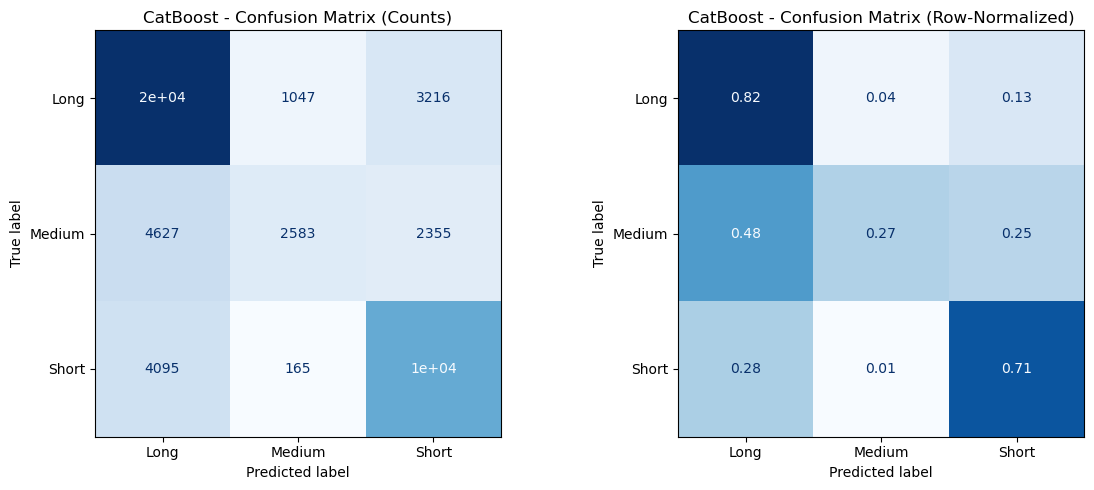


Detailed classification report (best model):
              precision    recall  f1-score   support

        Long       0.69      0.82      0.75     23961
      Medium       0.68      0.27      0.39      9565
       Short       0.65      0.71      0.68     14558

    accuracy                           0.68     48084
   macro avg       0.67      0.60      0.61     48084
weighted avg       0.68      0.68      0.66     48084



: 

In [ ]:

results = {}

model_list = []
for name, model in models.items():
    model.fit(X_train, y_train_cls)
    y_tr_pred = model.predict(X_train)
    y_te_pred = model.predict(X_test)

    tr = eval_metrics(y_train_cls, y_tr_pred, le)
    te = eval_metrics(y_test_cls,  y_te_pred,  le)

    results[name] = te  # store test metrics
    model_list.append(name)

    print(name)
    print(f"Train | Acc: {tr['acc']:.3f}  F1-macro: {tr['f1_macro']:.3f}  "
          f"Prec-macro: {tr['precision_macro']:.3f}  Rec-macro: {tr['recall_macro']:.3f}  "
          f"Recall(Long): {tr['recall_long']:.3f}  Precision(Short): {tr['precision_short']:.3f}")
    print(f"Test  | Acc: {te['acc']:.3f}  F1-macro: {te['f1_macro']:.3f}  "
          f"Prec-macro: {te['precision_macro']:.3f}  Rec-macro: {te['recall_macro']:.3f}  "
          f"Recall(Long): {te['recall_long']:.3f}  Precision(Short): {te['precision_short']:.3f}")
    print("-" * 70)

# Pick best by Macro-F1 (primary)
best_name = max(results, key=lambda k: results[k]["f1_macro"])
best_model = models[best_name]
print(f"\nBest model by F1-macro: {best_name}  -> {results[best_name]}")

# Confusion matrix + detailed report for best model
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test_cls, y_pred_best, labels=np.arange(len(le.classes_)))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title(f"{best_name} - Confusion Matrix (Counts)")

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(cm_norm, display_labels=le.classes_).plot(
    ax=ax[1], cmap="Blues", values_format=".2f", colorbar=False
)
ax[1].set_title(f"{best_name} - Confusion Matrix (Row-Normalized)")
plt.tight_layout(); plt.show()

print("\nDetailed classification report (best model):")
print(classification_report(
    y_test_cls, 
    y_pred_best, 
    target_names=[str(c) for c in le.classes_], 
    zero_division=0
))